# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.

In [1]:
import pandas as pd
import numpy as np
import os as os
import requests
import tweepy
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
df_tw = pd.read_csv('twitter-archive-enhanced.csv')
df_tw.head()


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
# download using library
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
#Save
with open ("image-predictions.tsv" , mode='wb') as file:
    file.write(response.content)

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [4]:
df_tw.shape

(2356, 17)

In [5]:
df_tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [6]:
df_tw.head

<bound method NDFrame.head of                 tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0     892420643555336193                    NaN                  NaN   
1     892177421306343426                    NaN                  NaN   
2     891815181378084864                    NaN                  NaN   
3     891689557279858688                    NaN                  NaN   
4     891327558926688256                    NaN                  NaN   
5     891087950875897856                    NaN                  NaN   
6     890971913173991426                    NaN                  NaN   
7     890729181411237888                    NaN                  NaN   
8     890609185150312448                    NaN                  NaN   
9     890240255349198849                    NaN                  NaN   
10    890006608113172480                    NaN                  NaN   
11    889880896479866881                    NaN                  NaN   
12    889665388333682689          

In [7]:
df_tw_image_pred = pd.read_csv('image-predictions.tsv', sep='\t')
df_tw_image_pred.head

<bound method NDFrame.head of                 tweet_id                                            jpg_url  \
0     666020888022790149    https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1     666029285002620928    https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2     666033412701032449    https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3     666044226329800704    https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4     666049248165822465    https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   
5     666050758794694657    https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg   
6     666051853826850816    https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg   
7     666055525042405380    https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg   
8     666057090499244032    https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg   
9     666058600524156928    https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg   
10    666063827256086533    https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg   
11    6660711932215091

In [8]:
df_tw_image_pred.info

<bound method DataFrame.info of                 tweet_id                                            jpg_url  \
0     666020888022790149    https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1     666029285002620928    https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2     666033412701032449    https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3     666044226329800704    https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4     666049248165822465    https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   
5     666050758794694657    https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg   
6     666051853826850816    https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg   
7     666055525042405380    https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg   
8     666057090499244032    https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg   
9     666058600524156928    https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg   
10    666063827256086533    https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg   
11    66607119322150

In [9]:
df_tw_image_pred.count()

tweet_id    2075
jpg_url     2075
img_num     2075
p1          2075
p1_conf     2075
p1_dog      2075
p2          2075
p2_conf     2075
p2_dog      2075
p3          2075
p3_conf     2075
p3_dog      2075
dtype: int64

In [10]:
df_tw_image_pred.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [11]:
##with open("tweet_json.txt, encoding='utf-8') as json_file:
##          tweets = json.load(json_file)
##tweet_data = pd.read_csv("tweet_json.txt, encoding = 'utf-8') tweet_data

df_tweets_new = []

In [12]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_tw.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
#with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    ##for tweet_id in tweet_ids:
      ##  count += 1
       ## print(str(count) + ": " + str(tweet_id))
        ##try:
          ##  tweet = api.get_status(tweet_id, tweet_mode='extended')
           ## print("Success")
           ## json.dump(tweet._json, outfile)
            ##outfile.write('\n')
        ##except tweepy.TweepError as e:
           ## print("Fail")
            ##fails_dict[tweet_id] = e
            ##pass
#end = timer()
##print(end - start)
##print(fails_dict)

In [13]:
with open("tweet-json") as file:
    for line in file:
        try:
            tw = json.loads(line)
            df_tweets_new.append(tw)
        except:
            continue
df_tweets_new = pd.DataFrame(df_tweets_new, columns=list(df_tweets_new[0].keys()))

In [14]:
df_tweets_new.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,None,None,False,8853,39467,False,False,False,False,en
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,None,None,False,6514,33819,False,False,False,False,en
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,None,None,False,4328,25461,False,False,False,False,en
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,None,None,False,8964,42908,False,False,False,False,en
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,None,None,False,9774,41048,False,False,False,False,en


In [15]:
df_tweets_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 27 columns):
created_at                       2354 non-null object
id                               2354 non-null int64
id_str                           2354 non-null object
full_text                        2354 non-null object
truncated                        2354 non-null bool
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
source                           2354 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null object
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 non-null object
in_reply_to_screen_name          78 non-null object
user                             2354 non-null object
geo                              0 non-null object
coordinates                      0 non-null

In [16]:
df_tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [17]:
df_tw_image_pred.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

In [18]:
df_tw_image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [19]:
df_tweets_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 27 columns):
created_at                       2354 non-null object
id                               2354 non-null int64
id_str                           2354 non-null object
full_text                        2354 non-null object
truncated                        2354 non-null bool
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
source                           2354 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null object
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 non-null object
in_reply_to_screen_name          78 non-null object
user                             2354 non-null object
geo                              0 non-null object
coordinates                      0 non-null

In [20]:
df_tweets_new.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,None,None,False,8853,39467,False,False,False,False,en
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,None,None,False,6514,33819,False,False,False,False,en
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,None,None,False,4328,25461,False,False,False,False,en
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,None,None,False,8964,42908,False,False,False,False,en
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,None,None,False,9774,41048,False,False,False,False,en


### Quality issues
1. df_tw ('twitter-archive-enhanced.csv'): timestamp of type "object" and need to be changed to "timestamp".

2. df_tw ('twitter-archive-enhanced.csv'): remove all records with empty expanded_urls (2356-2297) rows.

3. df_tw ('twitter-archive-enhanced.csv'): remove all non-empty retweeted_status_id (181) rows.

4. df_tw_image_pred ('image-predictions.tsv'): remove all duplicates from jpg_url (2075-2009) rows.

5. df_tw_image_pred ('image-predictions.tsv'): replace all UCase letters from p1, p2 and p3 with LCase.

6. df_tw_image_pred ('image-predictions.tsv'): replace all under score letters from p1, p2 and p3 with space.

7. df_tweets_new ("tweet-json"): drop the columns   "in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str and in_reply_to_screen_name" as all are insignificant.

8. df_tweets_new ("tweet-json"): delete column "id_str" as it is redundant from "id".

### Tidiness issues
1.df_tw ('twitter-archive-enhanced.csv'): Merge dog stage related columns (doggo, floofer, pupper and puppo) into a single column (dog_stage).

2.Join the 3 tables using "id" column to remove tweets that are not exsit in all the 3 data sources.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [21]:
# Make copies of original pieces of data
df_tw_copy = df_tw.copy()
df_tw_image_pred_copy = df_tw_image_pred.copy()
df_tweets_new_copy = df_tweets_new.copy()

### Issue #1:

#### Define: df_tw ('twitter-archive-enhanced.csv'): timestamp of type "object" and need to be changed to "timestamp".

#### Code

In [22]:
df_tw_copy['timestamp'] = pd.to_datetime(df_tw_copy['timestamp'])

#### Test

In [23]:
df_tw_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](1

### Issue #2:

#### Define: df_tw ('twitter-archive-enhanced.csv'): remove all records with empty expanded_urls (2356-2297) rows.


#### Code

In [24]:
df_tw_copy = df_tw_copy[df_tw_copy.expanded_urls.notnull()]

#### Test

In [25]:
df_tw_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2297 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2297 non-null datetime64[ns]
source                        2297 non-null object
text                          2297 non-null object
retweeted_status_id           180 non-null float64
retweeted_status_user_id      180 non-null float64
retweeted_status_timestamp    180 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2297 non-null int64
rating_denominator            2297 non-null int64
name                          2297 non-null object
doggo                         2297 non-null object
floofer                       2297 non-null object
pupper                        2297 non-null object
puppo                         2297 non-null object
dtypes: datetime64[ns](1

### Issue #3:

Define: df_tw ('twitter-archive-enhanced.csv'): remove all non-empty retweeted_status_id (181) rows.

Code:

In [26]:
df_tw_copy = df_tw_copy[df_tw_copy.retweeted_status_id.isnull()]

Test:

In [27]:
df_tw_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2117 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2117 non-null datetime64[ns]
source                        2117 non-null object
text                          2117 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2117 non-null int64
rating_denominator            2117 non-null int64
name                          2117 non-null object
doggo                         2117 non-null object
floofer                       2117 non-null object
pupper                        2117 non-null object
puppo                         2117 non-null object
dtypes: datetime64[ns](1), flo

### Issue #4:

Define: df_tw_image_pred ('image-predictions.tsv'): remove all duplicates from jpg_url (2075-2009) rows.

Code:

In [28]:
df_tw_image_pred_copy = df_tw_image_pred_copy.drop_duplicates(subset=['jpg_url'], keep='last')

Test:

In [29]:
df_tw_image_pred_copy['jpg_url'].duplicated().sum()

0

### Issue #5:

Define: df_tw_image_pred ('image-predictions.tsv'): replace all UCase letters from p1, p2 and p3 with LCase.

Code: 

In [30]:
df_tw_image_pred_copy['p1'] = df_tw_image_pred_copy['p1'].str.lower()
df_tw_image_pred_copy['p2'] = df_tw_image_pred_copy['p2'].str.lower()
df_tw_image_pred_copy['p3'] = df_tw_image_pred_copy['p3'].str.lower()

Test:

In [31]:
df_tw_image_pred_copy.head()
#now it is german_shepherd not German_Shepherd (3rd row)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


### Issue #6:

Define: df_tw_image_pred ('image-predictions.tsv'): replace all under score letters from p1, p2 and p3 with space.

Code:

In [32]:
df_tw_image_pred_copy['p1'] = df_tw_image_pred_copy['p1'].str.replace('_', ' ')
df_tw_image_pred_copy['p2'] = df_tw_image_pred_copy['p2'].str.replace('_', ' ')
df_tw_image_pred_copy['p3'] = df_tw_image_pred_copy['p3'].str.replace('_', ' ')

Test:

In [33]:
df_tw_image_pred_copy.head()
#now it is german shepherd not german_shepherd (3rd row)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh springer spaniel,0.465074,True,collie,0.156665,True,shetland sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature pinscher,0.074192,True,rhodesian ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian ridgeback,0.408143,True,redbone,0.360687,True,miniature pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


### Issue #7:

Define: df_tweets_new ("tweet-json"): 

drop the columns: 

in_reply_to_status_id

in_reply_to_status_id_str

in_reply_to_user_id

in_reply_to_user_id_str

in_reply_to_screen_name 

as all are insignificant.

Code:

In [34]:
df_tweets_new_copy.drop(['in_reply_to_status_id','in_reply_to_status_id_str','in_reply_to_user_id','in_reply_to_user_id_str','in_reply_to_screen_name'],axis=1,inplace=True)

Test:

In [35]:
df_tweets_new_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 22 columns):
created_at                       2354 non-null object
id                               2354 non-null int64
id_str                           2354 non-null object
full_text                        2354 non-null object
truncated                        2354 non-null bool
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
source                           2354 non-null object
user                             2354 non-null object
geo                              0 non-null object
coordinates                      0 non-null object
place                            1 non-null object
contributors                     0 non-null object
is_quote_status                  2354 non-null bool
retweet_count                    2354 non-null int64
favorite_count                   2354 non-null 

### Issue #8:

Define: delete column "id_str" as it is redundant from "id".

Code:

In [36]:
df_tweets_new_copy.drop('id_str', axis=1, inplace=True)


Test:

In [37]:
df_tweets_new_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 21 columns):
created_at                       2354 non-null object
id                               2354 non-null int64
full_text                        2354 non-null object
truncated                        2354 non-null bool
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
source                           2354 non-null object
user                             2354 non-null object
geo                              0 non-null object
coordinates                      0 non-null object
place                            1 non-null object
contributors                     0 non-null object
is_quote_status                  2354 non-null bool
retweet_count                    2354 non-null int64
favorite_count                   2354 non-null int64
favorited                        2354 non-null b

## Tideniss Issue:

Define: df_tw ('twitter-archive-enhanced.csv'): Merge dog stage related columns (doggo, floofer, pupper and puppo) into a single column (dog_stage).

Code:

In [38]:
df_tw_copy.doggo.replace('None', '', inplace=True)
df_tw_copy.floofer.replace('None', '', inplace=True)
df_tw_copy.pupper.replace('None', '', inplace=True)
df_tw_copy.puppo.replace('None', '', inplace=True)

df_tw_copy['dog_stage'] = df_tw_copy.doggo + df_tw_copy.floofer + df_tw_copy.pupper + df_tw_copy.puppo
df_tw_copy.loc[df_tw_copy.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
df_tw_copy.loc[df_tw_copy.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
df_tw_copy.loc[df_tw_copy.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

#df_tw_copy[df_tw_copy['text'].str.contains('floof')]
#df_tw_copy['dog_stage'] = df_tw_copy['text'].str.extract('(doggo|floof|pupper|puppo)',expand=True)
#df_tw_copy['dog_stage'].fillna('None', inplace=True)

In [39]:
df_tw_copy = df_tw_copy.drop(['doggo','floofer','pupper','puppo'], axis=1)

Test:

In [40]:
df_tw_copy.info()
df_tw_copy.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2117 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2117 non-null datetime64[ns]
source                        2117 non-null object
text                          2117 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2117 non-null int64
rating_denominator            2117 non-null int64
name                          2117 non-null object
dog_stage                     2117 non-null object
dtypes: datetime64[ns](1), float64(4), int64(3), object(6)
memory usage: 248.1+ KB


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [41]:
df_tweets_new_copy.rename(columns={"id": "tweet_id"}, inplace=True)
df_tweets_new_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 21 columns):
created_at                       2354 non-null object
tweet_id                         2354 non-null int64
full_text                        2354 non-null object
truncated                        2354 non-null bool
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
source                           2354 non-null object
user                             2354 non-null object
geo                              0 non-null object
coordinates                      0 non-null object
place                            1 non-null object
contributors                     0 non-null object
is_quote_status                  2354 non-null bool
retweet_count                    2354 non-null int64
favorite_count                   2354 non-null int64
favorited                        2354 non-null b

In [42]:
df_twitter_archive_master = df_tw_copy.merge(df_tw_image_pred_copy, how='inner', on='tweet_id')
df_twitter_archive_master = df_twitter_archive_master.merge(df_tweets_new_copy, how='inner', on='tweet_id')
df_twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928 entries, 0 to 1927
Data columns (total 45 columns):
tweet_id                         1928 non-null int64
in_reply_to_status_id            23 non-null float64
in_reply_to_user_id              23 non-null float64
timestamp                        1928 non-null datetime64[ns]
source_x                         1928 non-null object
text                             1928 non-null object
retweeted_status_id              0 non-null float64
retweeted_status_user_id         0 non-null float64
retweeted_status_timestamp       0 non-null object
expanded_urls                    1928 non-null object
rating_numerator                 1928 non-null int64
rating_denominator               1928 non-null int64
name                             1928 non-null object
dog_stage                        1928 non-null object
jpg_url                          1928 non-null object
img_num                          1928 non-null int64
p1                               1

In [43]:
# export df_twitter_archive_master
df_twitter_archive_master.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [44]:
df_twitter_archive_master_final = pd.read_csv('twitter_archive_master.csv')
df_twitter_archive_master_final.info()
#df_twitter_archive_master_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1928 entries, 0 to 1927
Data columns (total 45 columns):
tweet_id                         1928 non-null int64
in_reply_to_status_id            23 non-null float64
in_reply_to_user_id              23 non-null float64
timestamp                        1928 non-null object
source_x                         1928 non-null object
text                             1928 non-null object
retweeted_status_id              0 non-null float64
retweeted_status_user_id         0 non-null float64
retweeted_status_timestamp       0 non-null float64
expanded_urls                    1928 non-null object
rating_numerator                 1928 non-null int64
rating_denominator               1928 non-null int64
name                             1928 non-null object
dog_stage                        295 non-null object
jpg_url                          1928 non-null object
img_num                          1928 non-null int64
p1                               1928 non-

In [45]:
df_twitter_archive_master_final_dog_count = df_twitter_archive_master_final.groupby('p1')['tweet_id'].count().reset_index(name='count')
df_twitter_archive_master_final_dog_count.sort_values(by=['count'], ascending=False).head(10)

,p1,count
134,golden retriever,128
180,labrador retriever,90
242,pembroke,87
76,chihuahua,75
257,pug,52
79,chow,38
251,pomeranian,38
274,samoyed,37
335,toy poodle,37
201,malamute,28


In [46]:
df_twitter_archive_master_final['timestamp'] = pd.to_datetime(df_twitter_archive_master_final['timestamp'])
df_twitter_archive_master_final['year'] = df_twitter_archive_master_final['timestamp'].dt.year
df_twitter_archive_master_final.head()
df_twitter_archive_master_final_dog_count2 = df_twitter_archive_master_final.groupby('year')['tweet_id'].count().reset_index(name='count')
df_twitter_archive_master_final_dog_count2.sort_values(by=['count'], ascending=False).head(10)

,year,count
1,2016,930
0,2015,652
2,2017,346


In [47]:
df_twitter_archive_master_final_dog_sum = df_twitter_archive_master_final.groupby('p1')['retweet_count'].sum().reset_index(name='sum')
df_twitter_archive_master_final_dog_sum.sort_values(by=['sum'], ascending=False).head(10)

,p1,sum
134,golden retriever,423022
180,labrador retriever,306021
242,pembroke,261586
274,samoyed,157406
76,chihuahua,137172
127,french bulldog,121782
251,pomeranian,106518
79,chow,102642
335,toy poodle,90478
118,eskimo dog,85840


### Insights:
1. Top 3 mentioned dogs in the tweets are: golden retriever,labrador retriever,pembroke

2. most tweets on dog were reported in 2016.

3. dog "samoyed" achived top 4 place in retweet (157406 retweets) although is was not one of the top 7 tweet count and was in the 8th position with only 37 tweets; so it could be one of the most dog with high retweet average pecentage (Number of retweets/Number of original tweet).

### Visualization

Text(0,0.5,'Number of dogs')

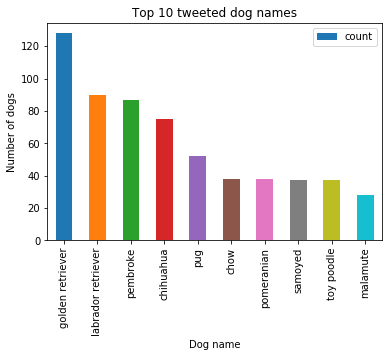

In [48]:
df = df_twitter_archive_master_final.groupby('p1')['tweet_id'].count().reset_index(name='count')
df = df.sort_values(by=['count'], ascending=False).head(10)
#df.head(10)
df.plot(x='p1', y='count',kind='bar')
plt.title('Top 10 tweeted dog names')
plt.xlabel('Dog name')
plt.ylabel('Number of dogs')                                                                                  